In [13]:
!pip install zarr xarray s3fs matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 85.2 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=5b838f4ba9e1912338ef1bdb76ca8c7fd24faf2e69ffa4cf190b72661df95c84
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [14]:
import zarr
import s3fs
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors

In [26]:
shot_id = 30462
endpoint_url = 'https://s3.echo.stfc.ac.uk'
url = f's3://mast/level1/shots/{shot_id}.zarr'

fs = fsspec.filesystem(
  **dict(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint_url)
  )
)


### Useful Signals

In [27]:
adg = xr.open_zarr(fs.get_mapper(url + '/adg'))
amc = xr.open_zarr(fs.get_mapper(url + '/amc'))
xim = xr.open_zarr(fs.get_mapper(url + '/xim'))
ane = xr.open_zarr(fs.get_mapper(url + '/ane'))

### H-mode Detection

In [49]:
tmin, tmax = 0.05, 0.3
threshold = 1

df = adg.density_gradient.to_pandas()
df /= 1e20
df = df.rolling(window=10, center=True).mean()
df.loc[df>threshold] = threshold
df = df.loc[tmin:tmax]

ip = amc.plasma_current.sel(time=slice(tmin, tmax))
ip = ip.sel(time=ip > 100)
max_ip = ip.time.values.max()
df.loc[df.index > max_ip] = 0

h_mode_times = df.index.values[df >= threshold]
h_mode = h_mode_times.min(), h_mode_times.max()
print(h_mode)

(0.103731744, 0.2021316)


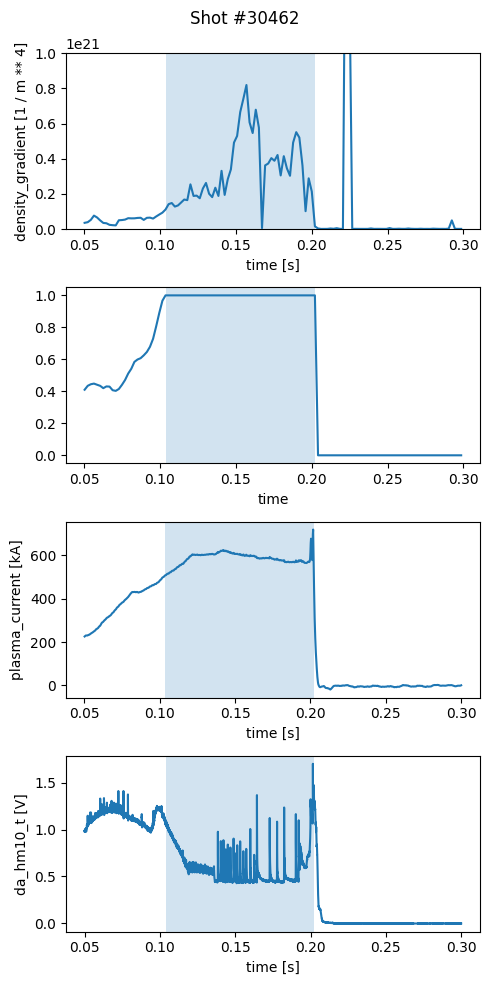

In [59]:
fig, axes = plt.subplots(4, 1, figsize=(5, 10))

adg.density_gradient.sel(time=slice(tmin, tmax)).plot(ax=axes[0])
axes[0].axvspan(h_mode[0], h_mode[1], alpha=0.2)
axes[0].set_ylim(0, 1e21)

df.plot(ax=axes[1])
axes[1].axvspan(h_mode[0], h_mode[1], alpha=0.2)

amc.plasma_current.sel(time=slice(tmin, tmax)).plot(ax=axes[2])
axes[2].axvspan(h_mode[0], h_mode[1], alpha=0.2)

xim.da_hm10_t.sel(time=slice(tmin, tmax)).plot(ax=axes[3])
axes[3].axvspan(h_mode[0], h_mode[1], alpha=0.2)

plt.suptitle(f'Shot #{shot_id}')
plt.tight_layout()